# Simplified self-attention (pretrained embeddings)

**Descrição**  
A *Simplified self-attention* é a forma mais básica do mecanismo de atenção, utilizada para introduzir a ideia central por trás da atenção em modelos de linguagem. Nessa versão simplificada, não há pesos treináveis: o foco está em compreender como cada token de uma sequência pode “olhar” para os demais tokens e combinar suas informações de maneira ponderada.  
Esse mecanismo já é suficiente para ilustrar como dependências entre palavras podem ser capturadas sem recorrer a estruturas recorrentes.

**Objetivo**  
O principal objetivo da *simplified self-attention* é demonstrar, de forma didática, como:
- tokens interagem entre si dentro de uma sequência;
- pesos de atenção são calculados a partir de similaridade entre representações;
- representações contextuais podem ser obtidas como combinações ponderadas dos tokens de entrada.  

Essa camada serve como base conceitual para versões mais avançadas de atenção, como a self-attention com pesos treináveis, atenção causal e multi-head attention.

**Funcionamento**  
De forma resumida, o funcionamento da *simplified self-attention* segue os passos abaixo:

1. Cada token de entrada é representado por um vetor (embedding).
2. Para um token de interesse, calcula-se a similaridade entre o seu vetor e os vetores de todos os tokens da sequência (por exemplo, via produto escalar).
3. Essas similaridades são normalizadas para formar pesos de atenção, geralmente usando uma função como *softmax*.
4. O vetor de saída do token é obtido como uma soma ponderada dos vetores de todos os tokens, usando os pesos de atenção calculados.
5. O processo é repetido para cada token da sequência, resultando em representações contextualizadas.

Mesmo sem parâmetros treináveis, esse mecanismo já evidencia o princípio fundamental da atenção: cada token decide dinamicamente o quanto deve considerar os demais tokens ao construir sua representação.


In [1]:
import json
import csv
import re
from dataclasses import asdict, dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


# Para reprodutibilidade
torch.manual_seed(42)

# -----------------------------------------------------------------------------
# Artefatos do pré-treino (gerados em "00 - Embedding de exemplo")
# -----------------------------------------------------------------------------
DATA_DIR = Path("../../data/mini_corpus_attn")
MODELS_DIR = Path("../../models/mini_corpus_attn")
MODEL_PATH = MODELS_DIR / "cbow_word_embeddings.pt"

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Tokenização compatível com o notebook 00 (remove pontuação e põe em minúsculas)
_WORD_RE = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ]+")

def tokenize_words(text: str, *, lowercase: bool = True) -> List[str]:
    """Tokeniza um texto em palavras (sem pontuação), preservando acentos."""
    if not isinstance(text, str):
        raise TypeError("text deve ser str")
    if lowercase:
        text = text.lower()
    return _WORD_RE.findall(text)

@dataclass
class TrainConfig:
    window_size: int = 2
    embed_dim: int = 2
    batch_size: int = 16
    epochs: int = 250
    lr: float = 0.05

def _artifacts_exist() -> bool:
    return all(
        p.exists() for p in [
            DATA_DIR / "corpus_raw.json",
            DATA_DIR / "token_to_id.json",
            DATA_DIR / "id_to_token.json",
            MODEL_PATH,
        ]
    )

def _bootstrap_pretrained_artifacts(config: TrainConfig) -> None:
    """Gera (de forma rápida) os mesmos artefatos do notebook 00, caso não existam."""
    corpus = [
        # Gato
        "O gato sobe no tapete.",
        "O gato desce do tapete.",
        "O gato sobe na mesa.",
        "O gato desce da mesa.",
        # Cachorro
        "O cachorro sobe no tapete.",
        "O cachorro desce do tapete.",
        "O cachorro sobe na mesa.",
        "O cachorro desce da mesa.",
        # Aranha
        "A aranha sobe na parede.",
        "A aranha desce da parede.",
        # Objetos
        "O tapete fica no chão.",
        "A mesa fica no chão.",
        "A parede fica no quarto.",
    ]

    tokenized_corpus: List[List[str]] = [tokenize_words(s) for s in corpus]

    # Vocab
    all_tokens = sorted(set(t for sent in tokenized_corpus for t in sent))
    token_to_id = {tok: i for i, tok in enumerate(all_tokens)}
    id_to_token = all_tokens

    # Salva corpus + vocab
    with open(DATA_DIR / "corpus_raw.json", "w", encoding="utf-8") as f:
        json.dump(corpus, f, ensure_ascii=False, indent=2)
    with open(DATA_DIR / "corpus_tokenized.json", "w", encoding="utf-8") as f:
        json.dump(tokenized_corpus, f, ensure_ascii=False, indent=2)
    with open(DATA_DIR / "token_to_id.json", "w", encoding="utf-8") as f:
        json.dump(token_to_id, f, ensure_ascii=False, indent=2)
    with open(DATA_DIR / "id_to_token.json", "w", encoding="utf-8") as f:
        json.dump(id_to_token, f, ensure_ascii=False, indent=2)

    # Samples CBOW
    def make_cbow_samples(
        tokenized: List[List[str]],
        token_to_id: Dict[str, int],
        window_size: int = 2
    ) -> List[Tuple[List[int], int]]:
        samples: List[Tuple[List[int], int]] = []
        for sent in tokenized:
            ids = [token_to_id[t] for t in sent]
            for i, target_id in enumerate(ids):
                left = ids[max(0, i - window_size): i]
                right = ids[i + 1: i + 1 + window_size]
                context = left + right
                if not context:
                    continue
                samples.append((context, target_id))
        return samples

    samples = make_cbow_samples(tokenized_corpus, token_to_id, window_size=config.window_size)

    class CBOWDataset(Dataset):
        def __init__(self, samples: List[Tuple[List[int], int]]):
            self.samples = samples
        def __len__(self) -> int:
            return len(self.samples)
        def __getitem__(self, idx: int) -> Tuple[List[int], int]:
            return self.samples[idx]

    def cbow_collate_fn(batch: List[Tuple[List[int], int]]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        contexts, targets = zip(*batch)
        max_len = max(len(c) for c in contexts)

        context_ids = torch.full((len(batch), max_len), fill_value=-1, dtype=torch.long)
        mask = torch.zeros((len(batch), max_len), dtype=torch.float32)
        for i, c in enumerate(contexts):
            context_ids[i, :len(c)] = torch.tensor(c, dtype=torch.long)
            mask[i, :len(c)] = 1.0

        target_ids = torch.tensor(targets, dtype=torch.long)
        return context_ids, mask, target_ids

    loader = DataLoader(
        CBOWDataset(samples),
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=cbow_collate_fn,
    )

    class CBOWModel(nn.Module):
        def __init__(self, vocab_size: int, embed_dim: int = 2):
            super().__init__()
            self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
            self.proj = nn.Linear(embed_dim, vocab_size)

        def forward(self, context_ids: torch.Tensor, context_mask: torch.Tensor) -> torch.Tensor:
            safe_ids = context_ids.clamp(min=0)
            ctx_emb = self.emb(safe_ids)  # (B,L,D)
            ctx_emb = ctx_emb * context_mask.unsqueeze(-1)  # máscara

            denom = context_mask.sum(dim=1).clamp(min=1.0).unsqueeze(-1)
            pooled = ctx_emb.sum(dim=1) / denom  # (B,D)

            logits = self.proj(pooled)  # (B,V)
            return logits

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CBOWModel(vocab_size=len(token_to_id), embed_dim=config.embed_dim).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

    # Logs (opcional)
    log_path = DATA_DIR / "training_log.csv"
    with open(log_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "avg_loss"])

    for epoch in range(1, config.epochs + 1):
        model.train()
        total_loss = 0.0
        n = 0

        for ctx_ids, ctx_mask, tgt_ids in loader:
            ctx_ids = ctx_ids.to(device)
            ctx_mask = ctx_mask.to(device)
            tgt_ids = tgt_ids.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(ctx_ids, ctx_mask)
            loss = loss_fn(logits, tgt_ids)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * tgt_ids.size(0)
            n += tgt_ids.size(0)

        avg_loss = total_loss / max(1, n)
        with open(log_path, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow([epoch, avg_loss])

    # Salva config e modelo (inclui embeddings)
    with open(DATA_DIR / "train_config.json", "w", encoding="utf-8") as f:
        json.dump(asdict(config), f, ensure_ascii=False, indent=2)

    torch.save(
        {
            "state_dict": model.state_dict(),
            "vocab_size": len(token_to_id),
            "embed_dim": config.embed_dim,
        },
        MODEL_PATH
    )

# Se não existir, faz bootstrap (deixa o notebook "standalone")
if not _artifacts_exist():
    config = TrainConfig()
    print("⚠️ Artefatos do pré-treino não encontrados; gerando agora (rápido)...")
    _bootstrap_pretrained_artifacts(config)

# Carrega artefatos
with open(DATA_DIR / "corpus_raw.json", "r", encoding="utf-8") as f:
    corpus: List[str] = json.load(f)

with open(DATA_DIR / "token_to_id.json", "r", encoding="utf-8") as f:
    token_to_id: Dict[str, int] = json.load(f)

with open(DATA_DIR / "id_to_token.json", "r", encoding="utf-8") as f:
    id_to_token: List[str] = json.load(f)

ckpt = torch.load(MODEL_PATH, map_location="cpu")
pretrained_emb_weight: torch.Tensor = ckpt["state_dict"]["emb.weight"].detach().clone()
embedding_dim: int = int(ckpt["embed_dim"])
vocab_size: int = int(ckpt["vocab_size"])

assert pretrained_emb_weight.shape == (vocab_size, embedding_dim)

print("DATA_DIR  :", DATA_DIR.resolve())
print("MODEL_PATH:", MODEL_PATH.resolve())
print(f"vocab_size={vocab_size} | embedding_dim={embedding_dim}")


DATA_DIR  : C:\Users\Enacom\Documents\GitHub\build_llm\data\mini_corpus_attn
MODEL_PATH: C:\Users\Enacom\Documents\GitHub\build_llm\models\mini_corpus_attn\cbow_word_embeddings.pt
vocab_size=17 | embedding_dim=2


## Tokenização + vocabulário (do pré-treino)

In [2]:
# Exemplo (mesmo domínio do corpus usado no pré-treino)
sentence = "O gato sobe no tapete."

# Tokenização compatível com o pré-treino
tokens = tokenize_words(sentence)

# Vocabulário pré-treinado
vocab = token_to_id
inv_vocab = {i: tok for i, tok in enumerate(id_to_token)}

print("Sentence:", sentence)
print("Tokens   :", tokens)
print("IDs      :", [vocab[t] for t in tokens])


Sentence: O gato sobe no tapete.
Tokens   : ['o', 'gato', 'sobe', 'no', 'tapete']
IDs      : [12, 8, 15, 11, 16]


## Conversão para token IDs

In [3]:
# Convertendo tokens para IDs (usando o vocabulário do pré-treino)
missing = [t for t in tokens if t not in vocab]
if missing:
    raise ValueError(f"Tokens fora do vocabulário: {missing}")

token_ids = torch.tensor([vocab[token] for token in tokens], dtype=torch.long)
token_ids


tensor([12,  8, 15, 11, 16])

## Camada de Embedding (pesos pré-treinados)

Aqui está o ponto-chave: usamos embeddings mas sem treinamento.

In [4]:
# Camada de embedding inicializada com pesos pré-treinados (CBOW)
# (congelada, apenas para demonstração)
embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
embedding_layer.weight = nn.Parameter(pretrained_emb_weight, requires_grad=False)

# Obtendo os embeddings para a frase de exemplo
embeddings = embedding_layer(token_ids)
embeddings


tensor([[ 7.1832,  3.2946],
        [-5.6417, -2.9633],
        [-0.6674,  8.2021],
        [ 5.7833, -9.7653],
        [-6.6097, -0.6122]])

## Cálculo da matriz de similaridade (attention scores)

Aqui aparece claramente o coração da self-attention

* Cada linha → token foco
* Cada coluna → token observado
* Valores maiores → maior similaridade

In [5]:
# Produto escalar entre todos os embeddings
# (Q = K = V = embeddings)
attention_scores = embeddings @ embeddings.T

attention_scores

tensor([[ 62.4520, -50.2878,  22.2283,   9.3697, -49.4957],
        [-50.2878,  40.6096, -20.5399,  -3.6900,  39.1041],
        [ 22.2283, -20.5399,  67.7201, -83.9562,  -0.6102],
        [  9.3697,  -3.6900, -83.9562, 128.8080, -32.2473],
        [-49.4957,  39.1041,  -0.6102, -32.2473,  44.0632]])

## Normalização com softmax (pesos de atenção)

In [6]:
# Softmax linha a linha
attention_weights = F.softmax(attention_scores, dim=1)

attention_weights


tensor([[1.0000e+00, 0.0000e+00, 3.3968e-18, 8.8441e-24, 0.0000e+00],
        [2.7336e-40, 8.1839e-01, 2.2704e-27, 4.7198e-20, 1.8161e-01],
        [1.7504e-20, 4.6683e-39, 1.0000e+00, 0.0000e+00, 2.1112e-30],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [2.3165e-41, 6.9701e-03, 3.9405e-20, 7.1736e-34, 9.9303e-01]])

## Visualizando os pesos de atenção (legível)

### Inicialmente apenas para o token gato

In [7]:
# Índice do token foco
token_foco = "gato"
idx_foco = 1

# Scores de similaridade do token "gato" com todos os tokens
scores_gato = attention_scores[idx_foco]

# Pesos de atenção após softmax
weights_gato = attention_weights[idx_foco]

* "gato" → tapete recebe peso alto
* "gato" → sobe recebe atenção moderada
* "gato" → O" recebe atenção baixa

Isso não é semântico ainda, é puramente geométrico (similaridade de embeddings).

In [8]:
print(f"Token foco: '{token_foco}'\n")

for token, weight in zip(tokens, weights_gato):
    print(f"Atenção em '{token:<7}': {weight.item():.3f}")

Token foco: 'gato'

Atenção em 'o      ': 0.000
Atenção em 'gato   ': 0.818
Atenção em 'sobe   ': 0.000
Atenção em 'no     ': 0.000
Atenção em 'tapete ': 0.182


### Entre todos os tokens

In [9]:
for i, token in enumerate(tokens):
    print(f"\nToken foco: '{token}'")
    for j, weight in enumerate(attention_weights[i]):
        print(f"  atenção em '{tokens[j]}': {weight.item():.3f}")


Token foco: 'o'
  atenção em 'o': 1.000
  atenção em 'gato': 0.000
  atenção em 'sobe': 0.000
  atenção em 'no': 0.000
  atenção em 'tapete': 0.000

Token foco: 'gato'
  atenção em 'o': 0.000
  atenção em 'gato': 0.818
  atenção em 'sobe': 0.000
  atenção em 'no': 0.000
  atenção em 'tapete': 0.182

Token foco: 'sobe'
  atenção em 'o': 0.000
  atenção em 'gato': 0.000
  atenção em 'sobe': 1.000
  atenção em 'no': 0.000
  atenção em 'tapete': 0.000

Token foco: 'no'
  atenção em 'o': 0.000
  atenção em 'gato': 0.000
  atenção em 'sobe': 0.000
  atenção em 'no': 1.000
  atenção em 'tapete': 0.000

Token foco: 'tapete'
  atenção em 'o': 0.000
  atenção em 'gato': 0.007
  atenção em 'sobe': 0.000
  atenção em 'no': 0.000
  atenção em 'tapete': 0.993


### Visualização da Self-Attention como Heatmap

Nesta célula, vamos visualizar a matriz de self-attention como um **heatmap**,
onde:

- linhas representam o **token foco**
- colunas representam os **tokens observados**
- valores representam os **pesos de atenção**

Vamos destacar visualmente a linha correspondente ao token **"gato"**.

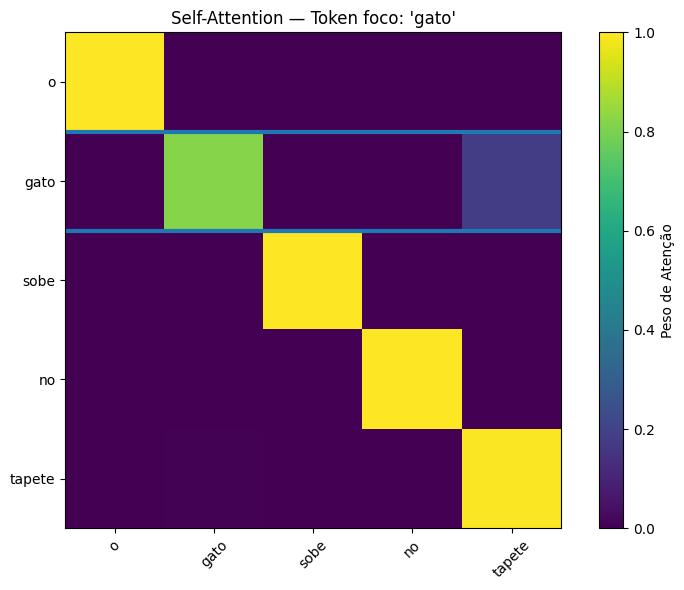

In [10]:
# Converter para numpy para facilitar o plot
attention_matrix = attention_weights.detach().numpy()

token_foco = "gato"
idx_gato = tokens.index(token_foco)

plt.figure(figsize=(8, 6))

plt.imshow(attention_matrix)
plt.colorbar(label="Peso de Atenção")

plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)

# Destaque correto da linha do "gato"
plt.axhline(idx_gato - 0.5, linewidth=3)
plt.axhline(idx_gato + 0.5, linewidth=3)

plt.title("Self-Attention — Token foco: 'gato'")

plt.tight_layout()
plt.show()

## Embeddings contextualizados (saída da atenção)

In [11]:
# Combinação ponderada dos embeddings
contextual_embeddings = attention_weights @ embeddings

contextual_embeddings

tensor([[ 7.1832,  3.2946],
        [-5.8175, -2.5363],
        [-0.6674,  8.2021],
        [ 5.7833, -9.7653],
        [-6.6030, -0.6286]])

### Embedding contextualizado apenas para o token 'Gato'

In [12]:
# Embedding original do token "gato"
embedding_original_gato = embeddings[idx_foco]

# Embedding contextualizado via self-attention
embedding_contextual_gato = weights_gato @ embeddings

print("Token:", token_foco)
print("\nEmbedding original:")
print(embedding_original_gato.detach().numpy())

print("\nEmbedding contextualizado:")
print(embedding_contextual_gato.detach().numpy())

Token: gato

Embedding original:
[-5.641666  -2.9633014]

Embedding contextualizado:
[-5.817477  -2.5363176]


### Embedding contextualizado entre todos os tokens

In [13]:
for i, token in enumerate(tokens):
    print(f"\nPalavra: '{token}'")
    print("Embedding original:      ", embeddings[i].detach().numpy())
    print("Embedding contextualizado:", contextual_embeddings[i].detach().numpy())


Palavra: 'o'
Embedding original:       [7.1831517 3.294591 ]
Embedding contextualizado: [7.1831517 3.294591 ]

Palavra: 'gato'
Embedding original:       [-5.641666  -2.9633014]
Embedding contextualizado: [-5.817477  -2.5363176]

Palavra: 'sobe'
Embedding original:       [-0.66743684  8.202114  ]
Embedding contextualizado: [-0.66743684  8.202114  ]

Palavra: 'no'
Embedding original:       [ 5.7833123 -9.765311 ]
Embedding contextualizado: [ 5.7833123 -9.765311 ]

Palavra: 'tapete'
Embedding original:       [-6.6097183 -0.6122487]
Embedding contextualizado: [-6.602971  -0.6286359]
